In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('weather_data_beirut_15year.csv', parse_dates=['dt'])

df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

features = ['temp', 'pressure', 'humidity', 'clouds', 'wind_speed', 'wind_deg']
data = df[features].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")

def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.15)
test_size = len(X) - train_size - valid_size

X_train, X_valid, X_test = X[:train_size], X[train_size:train_size+valid_size], X[train_size+valid_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[train_size+valid_size:]

print(f"Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}")
print(f"Train shape: {y_train.shape}, Validation shape: {y_valid.shape}, Test shape: {y_test.shape}")

Scaler saved successfully!
Train shape: (92030, 24, 6), Validation shape: (19720, 24, 6), Test shape: (19722, 24, 6)
Train shape: (92030, 6), Validation shape: (19720, 6), Test shape: (19722, 6)


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(6)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid),callbacks=[early_stop, checkpoint])

Epoch 1/20


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2876/2876 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - loss: 0.0234 - val_loss: 0.0102
Epoch 2/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 3/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 4/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 5/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 6/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 7/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 8/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 9/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 10/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - loss: 0.0071 - val_loss: 0.0081
Epoch 11/20
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 12/20
2876/28

617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
(19722, 6)
MAE: 0.69
RMSE: 0.90


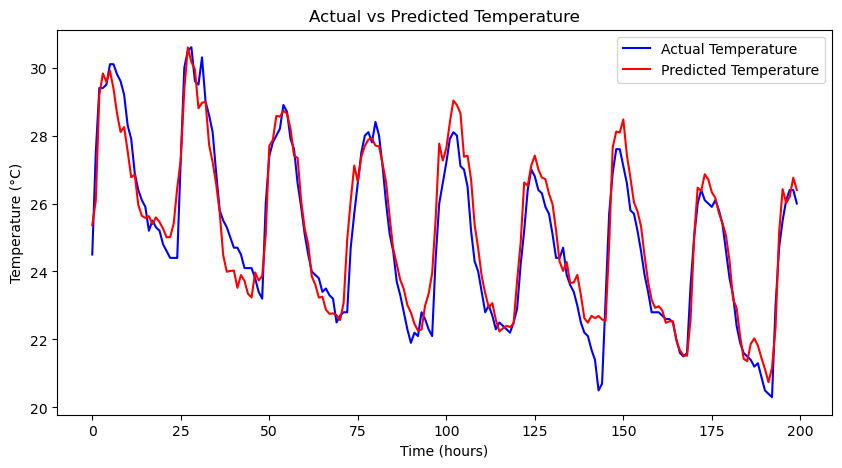

In [6]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), 0))])
y_pred_inv = scaler.inverse_transform(np.c_[y_pred, np.zeros((len(y_pred), 0))])

print(y_test_inv.shape)

mae = mean_absolute_error(y_test_inv[:,0], y_pred_inv[:,0])
rmse = np.sqrt(mean_squared_error(y_test_inv[:,0], y_pred_inv[:,0]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:200,0], label="Actual Temperature", color='blue')
plt.plot(y_pred_inv[:200,0], label="Predicted Temperature", color='red')
plt.legend()
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.show()

In [10]:
scaler=joblib.load("scaler.pkl")
model=load_model("best_model.keras")

yes = pd.read_csv('weather_data.csv', parse_dates=['dt'])

yes['dt'] = pd.to_datetime(yes['dt'])
yes.set_index('dt', inplace=True)

features = ['temp', 'pressure', 'humidity', 'clouds', 'wind_speed', 'wind_deg']
yesterday_data = yes[features].values

yesterday_scaled = scaler.transform(yesterday_data)

print(yesterday_scaled.shape)

yesterday_scaled = yesterday_scaled.reshape(1, 24, 6)
print(yesterday_scaled.shape)


(24, 6)
(1, 24, 6)


In [11]:
for i in range(24):
    today_pred = model.predict(yesterday_scaled)
    yesterday_scaled = yesterday_scaled[:, 1:, :]
    today_pred = today_pred.reshape(1, 1, 6)
    yesterday_scaled = np.append(yesterday_scaled, today_pred, axis=1) 
    
today_pred_inv=scaler.inverse_transform(yesterday_scaled[0])

print("Predicted Temperatures for Today:")
print(today_pred_inv[:, 0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Temperatures for Today:
[10.55414965 10.59096558 10.57047288 10.61126099 10.6

In [13]:
print(tf.__version__)

2.18.0
